In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [3]:
#csv_path = '2025-11-02_selected.csv'
#csv_path = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-24_preprocessed.csv'
csv_path = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv'
sel = pd.read_csv(csv_path)
sel

,Unnamed: 0,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,...,artifacts.valid,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,dims_error
0,0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.294375e-08
1,1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.319075e-08
2,2,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},1,{'ChestOfDrawers'},1,True,(),0.019631,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,8.319422e-08
3,3,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Desktop', 'Computer'}",2,"{'Desktop', 'Computer'}",2,True,(),0.025252,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.077898e-07
4,4,wss.107637b6bdf8129d4904d89e9169817b,{'Couch'},1,{'Couch'},1,True,(),0.022625,True,...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.520307e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1108,wss.d2014ddbb4e91d7ecb1a776b5576b46b,{'Couch'},1,{'Couch'},1,True,(),0.024101,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
941,1109,wss.d37fc7d310906d81350844aa00c7f347,{'TrashBin'},1,{'TrashBin'},1,True,(),0.011182,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
942,1111,wss.d81f943065391492a7e760c0b399301,"{'FoodItem', 'Bowl', '_StanfordSceneDBModels',...",4,"{'FoodItem', 'Bowl', 'FruitBowl'}",3,True,(),0.001381,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
943,1112,wss.d8d4004791c4f61b80fa98b5eeb7036c,"{'_StanfordSceneDBModels', 'Book'}",2,{'Book'},1,True,(),0.000002,True,...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN


In [4]:
base_dir = '2025-11-04_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-02_config.json')
len(grid)

1115

In [5]:
base_dir = '2025-11-06_optimize'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1115

In [6]:
base_dir = '2025-11-08_optimize' # fixed node labeling- use cell labels as GT, map cell -> point data, P0 scalars in forward sim

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config {config} --subject {subject} --output {output_path}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1115

In [7]:
base_dir = '2025-11-24_optimize' # post CVPR- new material catalog, rho known experiment

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.physics_adapter.rho_known={rho_known}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, rho_known=[True, False], variant='2025-11-20', config='2025-11-20_config.yaml')
len(grid)

2230

In [8]:
base_dir = '2026-01-13_optimize' # ECCV- full subject set

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.physics_adapter.rho_known={rho_known}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, rho_known=[True, False], variant='2025-01-05', config='2025-11-20_config.yaml')
len(grid)

2230

In [5]:
#base_dir = '2026-01-13_optimize' # ECCV- uniform material prior, DICE score + rasterization
#base_dir = '2026-01-24_optimize' # ECCV- filter out single-material preprocessed examples
base_dir = '2026-01-26_optimize' # ECCV- fix per-subject seed for material sampling

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --mem=22750M
#SBATCH -x v020
#SBATCH -t 24:00:00

source ~/.bashrc
set -eo pipefail

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/optimize.py {config} \\
    --set dataset.examples.subjects={subject} \\
    --set optimization.physics_adapter.rho_known={rho_known}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, rho_known=[True, False], variant='2026-01-15', config='2026-01-15_config.yaml')
len(grid)

1890

In [6]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=False)
except OSError:
    jobs = ps.load(base_dir)

jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
0,8cb03f00498ceb7e,RUNNING,2,37170031,v004,3:53,| └── 'lr': 0.0001\n └── 'trainer...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,True,2026-01-27T02:21:29,False,None,None
1,5063ce4526ce825f,RUNNING,2,37170032,v005,3:53,Optimizing subject: wss.100f39dce7690f59efb947...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,True,2026-01-27T02:21:29,False,None,None
2,b51e311be878d90f,RUNNING,2,37170033,v009,3:53,| └── 'lr': 0.0001\n └── 'trainer...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,True,2026-01-27T02:21:29,False,None,None
3,8a7efcdf9af3aadb,RUNNING,2,37170034,v008,3:53,| └── 'lr': 0.0001\n └── 'trainer...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,True,2026-01-27T02:21:29,False,None,None
4,7d66e5cef75938d1,RUNNING,2,37170035,v008,3:53,└── 'trainer': dict(len=2)\n ...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,True,2026-01-27T02:21:29,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,2963ccfa744d1a4f,PENDING,2,37171918,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,None,None,False,None,None
1886,bbb95c8c33283389,PENDING,2,37171919,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,None,None,False,None,None
1887,69a9209342f5e791,PENDING,2,37171920,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,None,None,False,None,None
1888,c7e0459d4315b6fa,PENDING,2,37171921,(Priority),0:00,None,None,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,status,None,None,False,None,None


In [7]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,1887,1887,1887,1887,1887,11,11,1887,1887,1887,...,1887,1887,0,1887,1887,1887,1887,1887,0,0
FAILED,3,3,3,3,3,0,0,3,3,3,...,3,3,0,3,3,3,3,3,0,0


In [8]:
jobs = ps.collect(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,1887,1887,1887,1887,1887,1887,1887,1887,1887,1887,...,1887,1887,0,1887,1887,1887,1887,1887,0,0
FAILED,3,3,3,3,3,3,3,3,3,3,...,3,3,0,3,3,3,3,3,0,0


In [13]:
j = 2
failed_jobs = jobs[jobs.job_state == 'FAILED']
print(failed_jobs.iloc[j])
print(failed_jobs.iloc[j].stderr)

job_name                                             4629018d45d25beb
job_state                                                      FAILED
n_submits                                                           2
job_id                                                       37170048
node_id                                                          v034
runtime                                                      00:00:09
stdout                  |   └── 'upper_bound':   6.0\n    ├── 'phy...
stderr              Traceback (most recent call last):\n  File "/o...
base_dir            /ocean/projects/asc170022p/mtragoza/lung-proje...
work_dir            /ocean/projects/asc170022p/mtragoza/lung-proje...
script_path         /ocean/projects/asc170022p/mtragoza/lung-proje...
output_path         /ocean/projects/asc170022p/mtragoza/lung-proje...
log_dir             /ocean/projects/asc170022p/mtragoza/lung-proje...
stdout_path         /ocean/projects/asc170022p/mtragoza/lung-proje...
stderr_path         

In [14]:
failed_jobs.node_id.unique()

array(['v013', 'v022', 'v034'], dtype=object)

In [20]:
jobs.loc[jobs.job_state == 'FAILED', 'job_id'] = pd.NA

array(['37170031', '37170032', '37170033', ..., '37171920', '37171921',
       '37171922'], shape=(1888,), dtype=object)

In [21]:
jobs = ps.submit(jobs)
jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
0,8cb03f00498ceb7e,COMPLETED,2,37170031,v004,00:09:28,WARNING: spearman_corr is undefined: pred is c...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
1,5063ce4526ce825f,COMPLETED,2,37170032,v005,00:05:37,WARNING: spearman_corr is undefined: target is...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
2,b51e311be878d90f,COMPLETED,2,37170033,v009,00:09:07,WARNING: spearman_corr is undefined: pred is c...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
3,8a7efcdf9af3aadb,COMPLETED,2,37170034,v008,00:09:25,WARNING: spearman_corr is undefined: target is...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
4,7d66e5cef75938d1,COMPLETED,2,37170035,v008,00:06:00,WARNING: spearman_corr is undefined: pred is c...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,2963ccfa744d1a4f,COMPLETED,2,37171918,v018,00:04:41,└── 'residual': MeshField()\n ├── cells: Te...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
1886,bbb95c8c33283389,COMPLETED,2,37171919,v023,00:03:27,└── 'residual': MeshField()\n ├── cells: Te...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
1887,69a9209342f5e791,COMPLETED,2,37171920,v021,00:03:26,└── 'residual': MeshField()\n ├── cells: Te...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>
1888,c7e0459d4315b6fa,COMPLETED,2,37171921,v022,00:01:59,└── 'residual': MeshField()\n ├── cells: Te...,,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,2026-01-27T02:31:03,history,True,2026-01-27T14:15:34,False,<NA>,<NA>


In [22]:
%autoreload
ex_df = ps.outputs(jobs, output_name='outputs/example_metrics.csv', skip_errors=True)
ex_df

Job 986e71da25e25a00: file not found
Job 4e28097542f72b10: file not found
Job 4629018d45d25beb: file not found


,epoch,phase,batch,step,loss,subject,num_voxels,E_vox.mean,E_vox.rms,E_vox.rmse,...,res_cell.mean,res_cell.rms,source_path,job_name,job_id,params_hash,params.subject,params.rho_known,params.variant,params.config
0,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,778627,1668.446429,1893.682611,272.243031,...,0.431390,0.797061,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,778627,2433.563088,17552.988561,17404.979568,...,0.430229,0.840392,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,0,optimize,0,0,0.000044,wss.101354f9d8dede686f7b08d9de913afe,772180,5351.599103,5990.626374,862.466262,...,0.072511,0.153674,/ocean/projects/asc170022p/mtragoza/lung-proje...,b51e311be878d90f,37170033,b51e311be878d90f,wss.101354f9d8dede686f7b08d9de913afe,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
3,0,optimize,0,0,0.000186,wss.101354f9d8dede686f7b08d9de913afe,772180,5771.090255,6768.040216,1903.353909,...,0.075159,0.165021,/ocean/projects/asc170022p/mtragoza/lung-proje...,8a7efcdf9af3aadb,37170034,8a7efcdf9af3aadb,wss.101354f9d8dede686f7b08d9de913afe,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
4,0,optimize,0,0,0.000036,wss.1029fd5d71a06ea32ea98d69e91ba870,243756,2844.373042,2884.564644,323.591638,...,1.054042,1.704859,/ocean/projects/asc170022p/mtragoza/lung-proje...,7d66e5cef75938d1,37170035,7d66e5cef75938d1,wss.1029fd5d71a06ea32ea98d69e91ba870,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,0,optimize,0,0,0.000083,wss.d81f943065391492a7e760c0b399301,231154,4420.517724,5317.810203,2492.681110,...,0.007184,0.012281,/ocean/projects/asc170022p/mtragoza/lung-proje...,2963ccfa744d1a4f,37171918,2963ccfa744d1a4f,wss.d81f943065391492a7e760c0b399301,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1883,0,optimize,0,0,0.000022,wss.d8d4004791c4f61b80fa98b5eeb7036c,352761,3190.683562,4065.023240,1208.456444,...,0.007695,0.012244,/ocean/projects/asc170022p/mtragoza/lung-proje...,bbb95c8c33283389,37171919,bbb95c8c33283389,wss.d8d4004791c4f61b80fa98b5eeb7036c,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1884,0,optimize,0,0,0.000359,wss.d8d4004791c4f61b80fa98b5eeb7036c,352761,4069.537957,5904.529988,3266.837916,...,0.007695,0.012442,/ocean/projects/asc170022p/mtragoza/lung-proje...,69a9209342f5e791,37171920,69a9209342f5e791,wss.d8d4004791c4f61b80fa98b5eeb7036c,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1885,0,optimize,0,0,0.000008,wss.8826babe37996d5ba7ceedb2540a32b0,96422,3526.907574,4438.786162,1427.350357,...,0.002928,0.004326,/ocean/projects/asc170022p/mtragoza/lung-proje...,c7e0459d4315b6fa,37171921,c7e0459d4315b6fa,wss.8826babe37996d5ba7ceedb2540a32b0,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...


In [23]:
%autoreload
mat_df = ps.outputs(jobs, output_name='outputs/material_metrics.csv', skip_errors=True)
mat_df

Job 986e71da25e25a00: file not found
Job 4e28097542f72b10: file not found
Job 4629018d45d25beb: file not found


,epoch,phase,batch,step,loss,subject,material,num_voxels,E_vox.mean,E_vox.rms,...,res_cell.mean,res_cell.rms,source_path,job_name,job_id,params_hash,params.subject,params.rho_known,params.variant,params.config
0,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,1053.918143,1074.383569,...,0.443996,0.796575,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2866.401347,2885.555378,...,0.406966,0.798002,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,2161.618482,21481.902769,...,0.441113,0.837417,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
3,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2963.689018,3023.212363,...,0.409144,0.846126,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
4,0,optimize,0,0,0.000044,wss.101354f9d8dede686f7b08d9de913afe,1,22904,2571.847575,2850.644237,...,0.031527,0.073178,/ocean/projects/asc170022p/mtragoza/lung-proje...,b51e311be878d90f,37170033,b51e311be878d90f,wss.101354f9d8dede686f7b08d9de913afe,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,1,48216,1438.019681,1733.188208,...,0.002065,0.003122,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5652,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,2,3701,2850.541585,3104.167744,...,0.001454,0.003063,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5653,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,3,2355,3292.057367,3619.586094,...,0.002326,0.002896,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5654,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,4,23375,3622.184732,3769.308774,...,0.002362,0.003472,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...


In [25]:
good_subjects = set(pd.read_csv(csv_path).subject)
len(good_subjects)

945

In [26]:
sys.path.append('../..')
import project.visual.matplotlib as mpl_viz
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# count missing values in each column
nnas = ex_df.isna().sum()
nnas

epoch                  0
phase                  0
batch                  0
step                   0
loss                   0
subject                0
num_voxels             0
E_vox.mean             0
E_vox.rms              0
E_vox.rmse             0
E_vox.nrmse            0
E_vox.srmse            0
E_vox.pcorr            0
E_vox.scorr            0
num_cells              0
volume                 0
rho_cell.mean          0
rho_cell.rms           0
rho_cell.rmse          0
rho_cell.nrmse         0
rho_cell.srmse      1887
rho_cell.pcorr      1887
rho_cell.scorr      1887
E_cell.mean            0
E_cell.rms             0
E_cell.rmse            0
E_cell.nrmse           0
E_cell.srmse           0
E_cell.pcorr          12
E_cell.scorr          12
u_cell.mean            0
u_cell.rms             0
u_cell.rmse            0
u_cell.nrmse           0
u_cell.srmse           0
u_cell.pcorr           0
u_cell.scorr           0
res_cell.mean          0
res_cell.rms           0
source_path            0


In [28]:
# count missing values and group by sets of missing columns
ex_df['subj_ok'] = ex_df.subject.isin(good_subjects)
ex_df['has_na'] = ex_df.isna().any(axis=1)

ex_df['u_norm_isna'] = ex_df['u_cell.rms'].isna()
ex_df['u_corr_isna'] = ex_df['u_cell.pcorr'].isna()

ex_df['E_norm_isna'] = ex_df['E_cell.rms'].isna()
ex_df['E_srmse_isna'] = ex_df['E_cell.srmse'].isna()
ex_df['E_corr_isna'] = ex_df['E_cell.pcorr'].isna()

ex_df['rho_norm_isna'] = ex_df['rho_cell.rms'].isna()
ex_df['rho_corr_isna'] = ex_df['rho_cell.pcorr'].isna()

ex_df.groupby([
    'subj_ok',
    'has_na',
    'E_norm_isna',
    'E_srmse_isna',
    'E_corr_isna',
    #'rho_norm_isna',
    #'rho_corr_isna',
    'u_norm_isna',
    'u_corr_isna',
]).count()

epoch  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False         1875   
                                        True        False       False           12   

                                                                             phase  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False         1875   
                                        True        False       False           12   

                                                                             batch  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False         1875   
                                        True        False       False           12   

                                                                             step  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna         
True    True   False       False        False       False       False        1875   
                                        True        False       False          12   

                                                                             loss  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna         
True    True   False       False        False       False       False        1875   
                                        True        False       False          12   

                                                                             subject  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna            
True    True   False       False        False       False       False           1875   
                                        True        False       False             12   

                                                                             num_voxels  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False              1875   
                                        True        False       False                12   

                                                                             E_vox.mean  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False              1875   
                                        True        False       False                12   

                                                                             E_vox.rms  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna              
True    True   False       False        False       False       False             1875   
                                        True        False       False               12   

                                                                             E_vox.rmse  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False              1875   
                                        True        False       False                12   

                                                                             ...  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna  ...   
True    True   False       False        False       False       False        ...   
                                        True        False       False        ...   

                                                                             source_path  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna                
True    True   False       Fal

In [29]:
ex_df[ex_df['params.rho_known']].groupby([
    'subj_ok',
    'has_na',
    'E_norm_isna',
    'E_srmse_isna',
    'E_corr_isna',
    #'rho_norm_isna',
    #'rho_corr_isna',
    'u_norm_isna',
    'u_corr_isna'
]).count()

epoch  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False          933   
                                        True        False       False           12   

                                                                             phase  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False          933   
                                        True        False       False           12   

                                                                             batch  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna          
True    True   False       False        False       False       False          933   
                                        True        False       False           12   

                                                                             step  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna         
True    True   False       False        False       False       False         933   
                                        True        False       False          12   

                                                                             loss  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna         
True    True   False       False        False       False       False         933   
                                        True        False       False          12   

                                                                             subject  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna            
True    True   False       False        False       False       False            933   
                                        True        False       False             12   

                                                                             num_voxels  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False               933   
                                        True        False       False                12   

                                                                             E_vox.mean  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False               933   
                                        True        False       False                12   

                                                                             E_vox.rms  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna              
True    True   False       False        False       False       False              933   
                                        True        False       False               12   

                                                                             E_vox.rmse  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna               
True    True   False       False        False       False       False               933   
                                        True        False       False                12   

                                                                             ...  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna  ...   
True    True   False       False        False       False       False        ...   
                                        True        False       False        ...   

                                                                             source_path  \
subj_ok has_na E_norm_isna E_srmse_isna E_corr_isna u_norm_isna u_corr_isna                
True    True   False       Fal

In [30]:
import numpy as np
ex_df['res_order'] = np.log10(ex_df['res_cell.rms'])
ex_df['u_order'] = np.log10(ex_df['u_cell.nrmse'])
ex_df['E_order'] = np.log10(ex_df['E_cell.nrmse'])
ex_df[['res_order', 'u_order', 'E_order']].describe().T

,count,mean,std,min,25%,50%,75%,max
res_order,1887.0,-0.642550,1.095012,-4.216260,-1.383849,-0.489314,0.301955,3.072027
u_order,1887.0,-2.471227,0.570257,-4.977032,-2.911790,-2.442439,-1.966523,-1.219901
E_order,1887.0,-0.607826,0.364200,-1.874729,-0.813524,-0.588846,-0.417105,1.452986


In [31]:
def classify_failure(row):
    if row['res_order'] > 2:
        return 'residual'
    elif row['u_order'] > 0:
        return 'u error hi'
    elif row['E_order'] > 0:
        return 'E error'
    return 'ok'

ex_df['failure_type'] = ex_df.apply(classify_failure, axis=1)
ex_df['failure_type'].value_counts()

failure_type
ok          1794
E error       89
residual       4
Name: count, dtype: int64

<Axes: xlabel='Count', ylabel='E_cell.nrmse'>

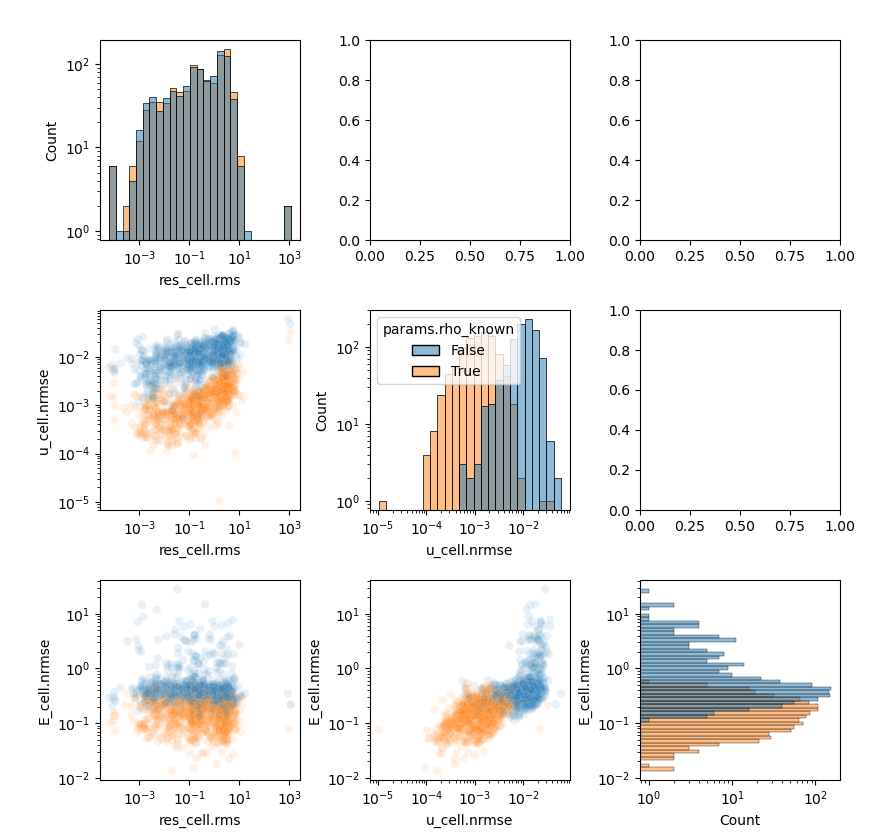

In [32]:
fig, axes = mpl_viz.subplot_grid(3, 3, ax_height=2, ax_width=2, padding=(1.0, 0.4, 0.6, 0.4), spacing=0.7) # lrbt

df = ex_df[ex_df.subj_ok]
hue = 'params.rho_known'

ax = axes[0,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='res_cell.rms', hue=hue, legend=False, ax=ax)

ax = axes[1,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='res_cell.rms', y='u_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[2,0]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='res_cell.rms', y='E_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[1,1]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, x='u_cell.nrmse', hue=hue, legend=True, ax=ax)

ax = axes[2,1]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.scatterplot(df, x='u_cell.nrmse', y='E_cell.nrmse', hue=hue, legend=False, ax=ax, alpha=0.1)

ax = axes[2,2]
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
sns.histplot(df, y='E_cell.nrmse', hue=hue, legend=False, ax=ax)


In [33]:
ex_df.groupby(['params.rho_known'])[['res_cell.rms', 'u_cell.nrmse', 'E_cell.nrmse']].describe()

res_cell.rms                                           \
                        count      mean        std       min       25%   
params.rho_known                                                         
False                   942.0  3.329774  47.299533  0.000061  0.040692   
True                    945.0  3.568397  50.464712  0.000071  0.041516   

                                                  u_cell.nrmse            ...  \
                       50%       75%          max        count      mean  ...   
params.rho_known                                                          ...   
False             0.320063  1.901465  1141.623822        942.0  0.011809  ...   
True              0.325135  2.108678  1180.394943        945.0  0.001635  ...   

                                     E_cell.nrmse                      \
                       75%       max        count      mean       std   
params.rho_known                                                        
False             0.015404  0.060270        942.0  0.665301  1.480040   
True              0.002065  0.032045        945.0  0.166213  0.088445   

                                                                     
                       min       25%       50%       75%        max  
params.rho_known                                                     
False             0.112156  0.295780  0.372024  0.473036  28.378277  
True              0.013344  0.097247  0.155928  0.215861   0.544482  

[2 rows x 24 columns]

<Axes: xlabel='params.rho_known', ylabel='mat_vox.dice'>

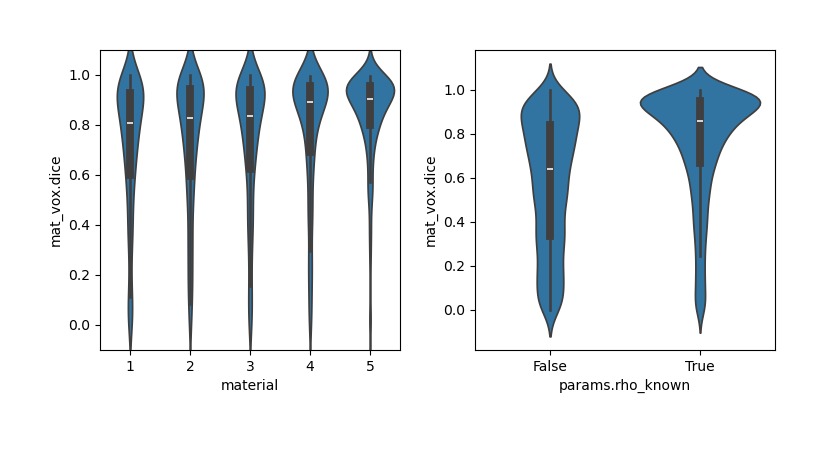

In [35]:
fig, axes = mpl_viz.subplot_grid(
    1, 2,
    ax_height=3,
    ax_width=3,
    padding=[1.0, 0.5, 1.0, 0.5], 
    spacing=[0.75, 0.75]
)

sns.violinplot(
    mat_df[
        (mat_df['params.rho_known'] == True)
    ],
    x='material',
    y='mat_vox.dice',
    ax=axes[0,0]
)
axes[0,0].set_ylim(-0.1, 1.1)

sns.violinplot(
    mat_df,
    x='params.rho_known',
    y='mat_vox.dice',
    ax=axes[0,1]
)

In [36]:
mat_df.groupby(['material'])['num_voxels'].sum()

material
1    159203158
2    158368364
3    145977058
4    152267354
5    154316727
Name: num_voxels, dtype: int64

In [38]:
mat_df

,epoch,phase,batch,step,loss,subject,material,num_voxels,E_vox.mean,E_vox.rms,...,res_cell.mean,res_cell.rms,source_path,job_name,job_id,params_hash,params.subject,params.rho_known,params.variant,params.config
0,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,1053.918143,1074.383569,...,0.443996,0.796575,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
1,0,optimize,0,0,0.000097,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2866.401347,2885.555378,...,0.406966,0.798002,/ocean/projects/asc170022p/mtragoza/lung-proje...,8cb03f00498ceb7e,37170031,8cb03f00498ceb7e,wss.100f39dce7690f59efb94709f30ce0d2,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
2,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,1,514631,2161.618482,21481.902769,...,0.441113,0.837417,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
3,0,optimize,0,0,0.001000,wss.100f39dce7690f59efb94709f30ce0d2,3,263996,2963.689018,3023.212363,...,0.409144,0.846126,/ocean/projects/asc170022p/mtragoza/lung-proje...,5063ce4526ce825f,37170032,5063ce4526ce825f,wss.100f39dce7690f59efb94709f30ce0d2,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
4,0,optimize,0,0,0.000044,wss.101354f9d8dede686f7b08d9de913afe,1,22904,2571.847575,2850.644237,...,0.031527,0.073178,/ocean/projects/asc170022p/mtragoza/lung-proje...,b51e311be878d90f,37170033,b51e311be878d90f,wss.101354f9d8dede686f7b08d9de913afe,True,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,1,48216,1438.019681,1733.188208,...,0.002065,0.003122,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5652,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,2,3701,2850.541585,3104.167744,...,0.001454,0.003063,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5653,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,3,2355,3292.057367,3619.586094,...,0.002326,0.002896,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...
5654,0,optimize,0,0,0.000021,wss.8826babe37996d5ba7ceedb2540a32b0,4,23375,3622.184732,3769.308774,...,0.002362,0.003472,/ocean/projects/asc170022p/mtragoza/lung-proje...,32f69b777cb9f43a,37171922,32f69b777cb9f43a,wss.8826babe37996d5ba7ceedb2540a32b0,False,2026-01-15,/ocean/projects/asc170022p/mtragoza/lung-proje...


In [39]:
(mat_df.groupby(['subject'])['material'].nunique() == 1).sum()

np.int64(0)

In [40]:
mat_df['subject'].nunique()

945

In [41]:
one_material = (mat_df.groupby(['subject'])['material'].nunique() == 1)
one_material_subjs = one_material[one_material == True]

one_material_rows = mat_df[mat_df.subject.isin(one_material_subjs.index)]

for i in range(1, 6):
    n = len(one_material_rows[one_material_rows.material == i])
    print(i, n)

1 0
2 0
3 0
4 0
5 0


In [43]:
mat_df.groupby('material')[['E_cell.nrmse', 'mat_vox.dice']].describe()

E_cell.nrmse                                                        \
                count      mean       std           min       25%       50%   
material                                                                      
1              1145.0  1.405390  2.601865  5.493164e-07  0.502715  0.928029   
2              1151.0  0.491134  0.606760  2.929688e-06  0.220941  0.367777   
3              1135.0  0.357113  0.608319  4.069010e-06  0.161705  0.274919   
4              1084.0  0.362849  0.610067  1.534765e-03  0.132610  0.249741   
5              1139.0  0.289510  0.277605  9.765625e-07  0.166419  0.255829   

                              mat_vox.dice                                     \
               75%        max        count      mean       std  min       25%   
material                                                                        
1         1.537624  48.393378       1145.0  0.677310  0.278018  0.0  0.524507   
2         0.598953  13.404579       1151.0  0.631146  0.298892  0.0  0.398881   
3         0.402892  12.059772       1137.0  0.624095  0.302211  0.0  0.371065   
4         0.400166   8.546600       1084.0  0.666309  0.290749  0.0  0.455801   
5         0.363033   6.169853       1139.0  0.753455  0.250242  0.0  0.664733   

                                        
               50%       75%       max  
material                                
1         0.764607  0.900082  0.998683  
2         0.711946  0.896186  0.999385  
3         0.701345  0.893000  0.998024  
4         0.768438  0.918273  0.997689  
5         0.850059  0.938909  0.994033

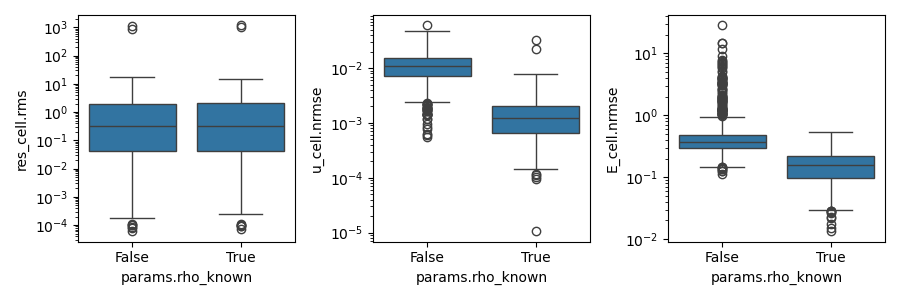

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
plot_fn = sns.boxplot
for ax in axes:
    ax.set_yscale('log')
plot_fn(df, x='params.rho_known', y='res_cell.rms', ax=axes[0])
plot_fn(df, x='params.rho_known', y='u_cell.nrmse', ax=axes[1])
plot_fn(df, x='params.rho_known', y='E_cell.nrmse', ax=axes[2])
fig.tight_layout()